In [1]:
import sys
sys.path.append("..")

import numpy as np
from tqdm import tqdm
from scipy import signal
from pathlib import Path
from utils.plot_utils import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import griddata
from sympy import Symbol, zeros, Function, MatrixSymbol

In [3]:
from julia import Main
Main.eval("Threads.nthreads()")

10

In [4]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000b44) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [5]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

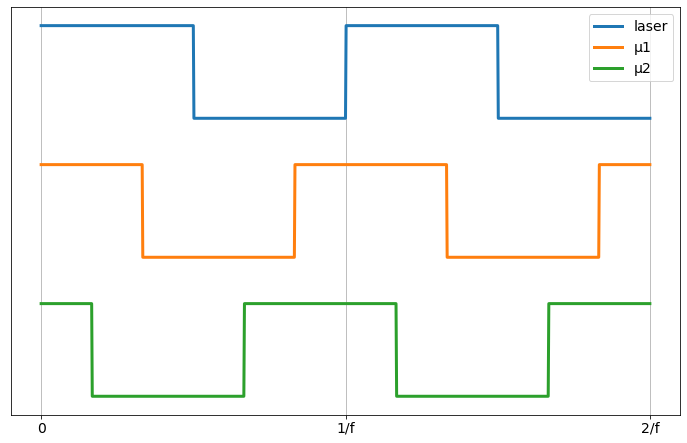

In [33]:
f = 1.
t = np.linspace(0,2,1001)
ϕ_laser = 0.
ϕ_μ1 = np.pi/3
ϕ_μ2 = 2*np.pi/3

fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t, [3+Main.square_wave(ti, f, ϕ_laser) for ti in t], lw = 3, label = 'laser')
ax.plot(t, [1.5+Main.square_wave(ti, f, ϕ_μ1) for ti in t], lw = 3, label = 'μ1')
ax.plot(t, [Main.square_wave(ti, f, ϕ_μ2) for ti in t], lw = 3, label = 'μ2')

ax.set_yticks([])
ax.set_xticks([0, 1,2])
ax.set_xticklabels(['0', '1/f', '2/f'])

ax.grid(True)

ax.legend(fontsize = 14)

set_fontsize(ax, 14)

In [5]:
# reading from file
with open('../ode_fun_mu1mu2.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [6]:
for l in ode_fun.split('\n')[:30]:
    print(l)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Ω1 = p[3]
		Ω1ᶜ = conj(Ω1)
		νp1 = p[4]
		Ω2 = p[5]
		νp2 = p[6]
		Ω2ᶜ = conj(Ω2)
		Δ = p[7]
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)    
		Pm1y = square_wave(t, νp1, 1.0471975511965976)
		Pm1z = square_wave(t, νp1, 4.1887902047863905)
		Pm2y = square_wave(t, νp2, 2.0943951023931953)
		Pm2z = square_wave(t, νp2, 5.235987755982988)
		du[1,1] = 3367347.38920463*ρ[65,65] + 3367525.85757618*ρ[66,66] + 3367704.32982945*ρ[67,67]
		du[1,2] = -83545.9813842773*1im*ρ[1,2]
		du[1,3] = -83566.3651275635*1im*ρ[1,3]
		du[1,4] = -83586.7483215332*1im*ρ[1,4]
		du[1,5] = -1.0*1im*(0.333333330908845*1im*Ω1ᶜ*ρ[1,17]*Pm1y - 0.471404517203288*Ω1ᶜ*ρ[1,18]*Pm1z + 0.333333330908771*1im*Ω1ᶜ*ρ[1,19]*Pm1y - 83783184618.4029*ρ[1,5])
		du[1,6] = -1.0*1im*(-0.249541612125025*Ω1ᶜ*ρ[1,17]*Pm1z + 0.176452566062313*1im*Ω1ᶜ*ρ[1,18]*Pm1y + 0.40303152920221*1im*Ω1ᶜ*ρ[1,20]*Pm1y - 0.4030315368

In [7]:
# defining the function in Julia
# make function smaller for testing purposes
# ode_fun = '\n'.join(ode_fun.split('\n')[1:300])
# ode_fun += '\n \t end \n \t nothing \n end'
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

### Generate density matrix

In [8]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [9]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [10]:
T = 6.3
ρ_ini = np.zeros([67,67], dtype = 'complex')

for J in range(0,4):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()

In [11]:
de_main = -0.39444661382277774 # main dipole transition moment

Γ = 1/(100e-9)
Ω =  1*Γ
ωp = Γ
νp = ωp/(2*np.pi)
νp1 = νp
Ω1 = 1*Γ
νp2 = νp
Ω2 = 1*Γ
Δ = 0

Main.Ω = Ω
Main.νp = νp
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Ω2 = Ω2
Main.νp2 = νp2
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Ω1, νp1, Ω2, νp2, Δ]")

array([10000000.        ,  1591549.43091895, 10000000.        ,
        1591549.43091895, 10000000.        ,  1591549.43091895,
              0.        ])

In [12]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@time Lindblad_rhs!(du, ρ_ini, [Ω, νp, Ω1, νp1, Ω2, νp2, Δ], 0.)
tmp = 0
""")

Wall time: 15min 9s


0

### Polarization switching frequency scan

In [13]:
Main.freqs = np.logspace(-3,1,201)*1e6
Main.params = Main.freqs

In [14]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617074914301e9, 1.617074914301e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000990) open, 0 bytes waiting), 0, 0, 0)>

In [15]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [16]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [17]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[Ω; params[i]; Ω1; params[i]; Ω2; params[i]; Δ])
end
""")

<PyCall.jlwrap prob_func>

In [18]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [19]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

531.9525102

In [20]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [21]:
result_freq_scan = np.empty([len(Main.params),67+1], dtype = 'complex')
result_freq_scan[:,0] = Main.params.copy()
result_freq_scan[:,1:] = ens_u.copy()

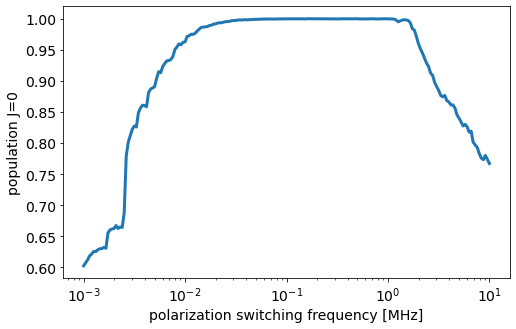

In [22]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(result_freq_scan[:,0].real/1e6, result_freq_scan[:,1:5].sum(axis = 1).real, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

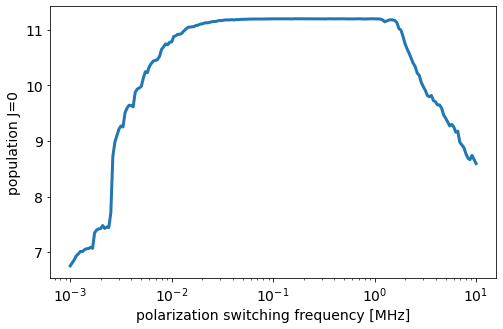

In [23]:
ratio = result_freq_scan[:,1:5].sum(axis = 1).real/np.diag(ρ_ini)[:4].sum().real
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(result_freq_scan[:,0].real/1e6, ratio, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

### Disable laser polarization switching

In [24]:
Main.freqs = np.logspace(-3,1,201)*1e6
Main.params = Main.freqs

In [25]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617075467872e9, 1.617075467872e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000990) open, 0 bytes waiting), 0, 0, 0)>

In [26]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [27]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [28]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[Ω; 0; Ω1; params[i]; Ω2; params[i]; Δ])
end
""")

<PyCall.jlwrap prob_func>

In [29]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [30]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

529.9194333

In [31]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [32]:
result_freq_scan = np.empty([len(Main.params),67+1], dtype = 'complex')
result_freq_scan[:,0] = Main.params.copy()
result_freq_scan[:,1:] = ens_u.copy()

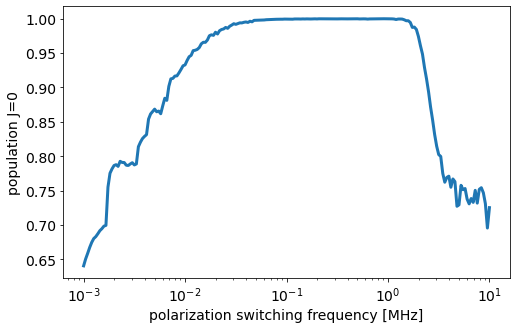

In [33]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(result_freq_scan[:,0].real/1e6, result_freq_scan[:,1:5].sum(axis = 1).real, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

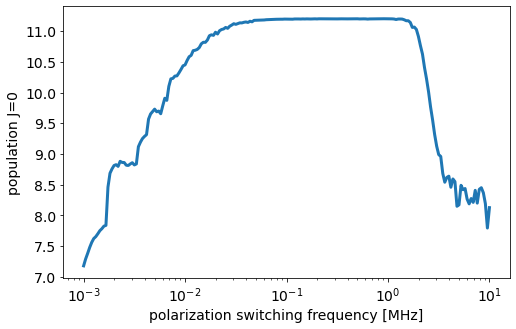

In [34]:
ratio = result_freq_scan[:,1:5].sum(axis = 1).real/np.diag(ρ_ini)[:4].sum().real
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(result_freq_scan[:,0].real/1e6, ratio, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

### No polarization switching (single trajectory)

In [100]:
Main.eval("p_nopol = [Ω, 0, Ω1, 0, Ω2, 0, Δ]");

In [101]:
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p_nopol)
tmp = 0
""")

0

5.798354086205415
Wall time: 13.1 s


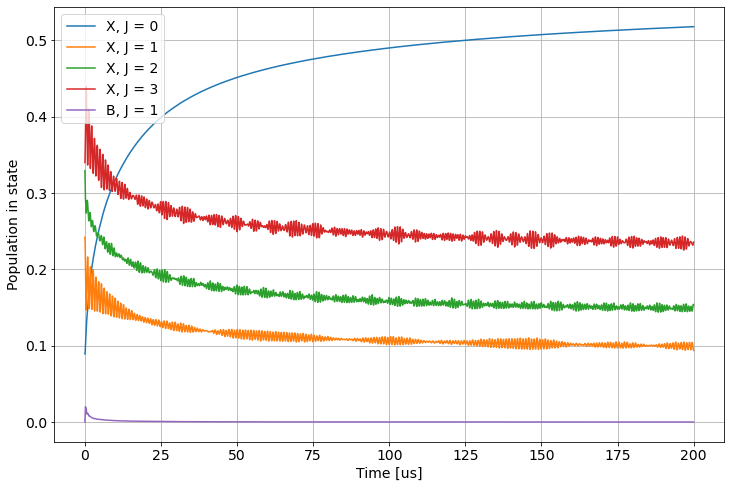

In [102]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, abstol = 1e-8, reltol = 1e-5)
tmp = 0
""")

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

### Only microwaves switching (single trajectory)

In [106]:
Main.eval("p_nopol = [Ω, 0, Ω1, 1e6, Ω2, 1e6, Δ]");

In [107]:
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p_nopol)
tmp = 0
""")

0

11.202099365213355
Wall time: 18.3 s


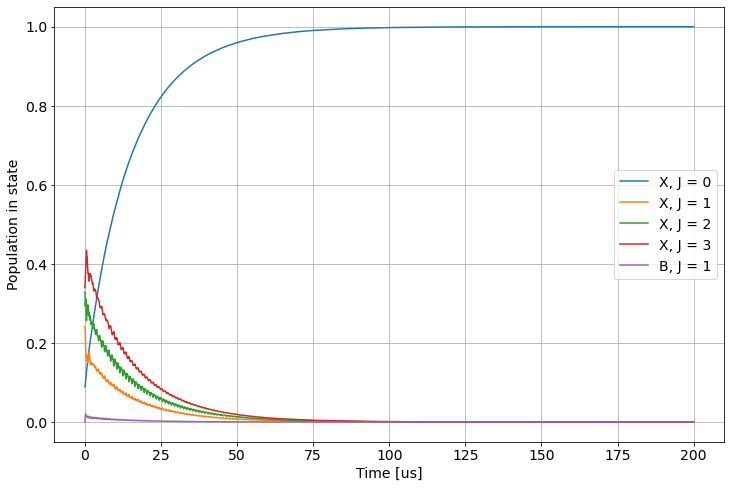

In [108]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, abstol = 1e-8, reltol = 1e-5)
tmp = 0
""")

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

### All switching (single trajectory)

In [109]:
Main.eval("p_nopol = [Ω, 1e6, Ω1, 1e6, Ω2, 1e6, Δ]");

In [110]:
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p_nopol)
tmp = 0
""")

0

11.201792841478381
Wall time: 1min 14s


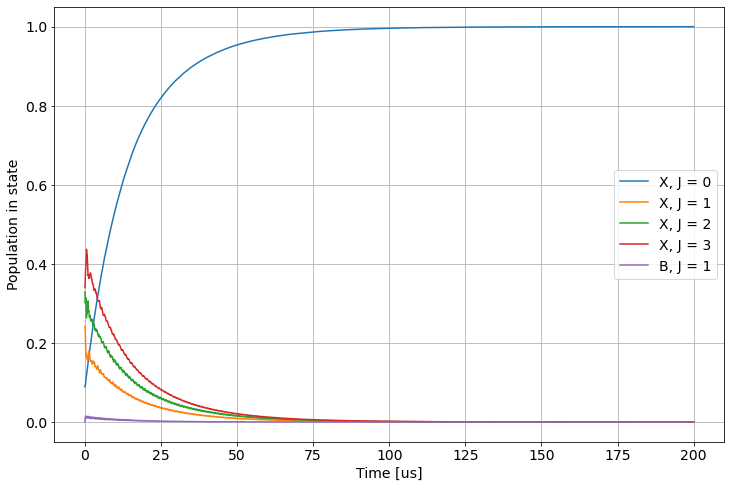

In [111]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, abstol = 1e-8, reltol = 1e-5)
tmp = 0
""")

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

### Only laser switching (single trajectory)Γ

In [63]:
Main.eval("p_nopol = [Ω, 1e6, Ω1, 0, Ω2, 0, Δ]");

In [64]:
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p_nopol)
tmp = 0
""")

0

8.373590510127677
Wall time: 16.9 s


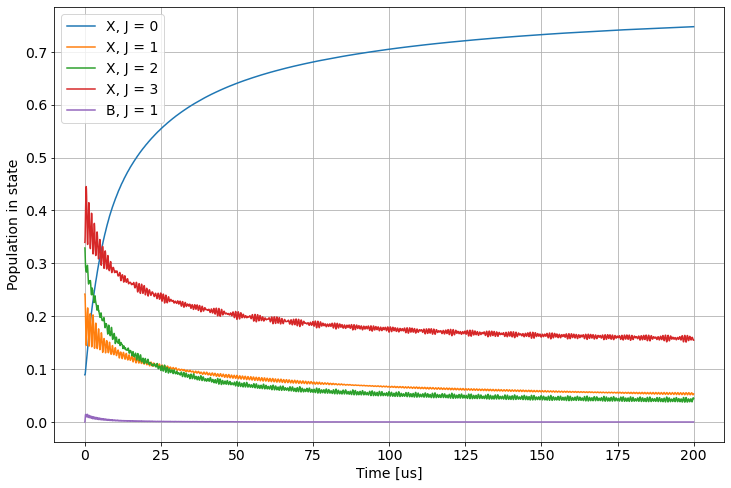

In [65]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, abstol = 1e-8, reltol = 1e-5)
tmp = 0
""")

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

### Disable laser polarization switching and scan Ω1

In [67]:
Main.freqs = np.logspace(-3,1,201)*1e6
Main.Ω1s = np.arange(0.5,3.5,0.5)*Ω1
params = np.zeros([len(Main.freqs)*len(Main.Ω1s), 2])
params[:,0] = np.repeat(Main.Ω1s, len(Main.freqs))
params[:,1] = np.tile(Main.freqs, len(Main.Ω1s))
Main.params = params

In [25]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617075467872e9, 1.617075467872e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000990) open, 0 bytes waiting), 0, 0, 0)>

In [26]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [27]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [68]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[Ω; 0; params[i,1]; params[i,2]; Ω2; params[i,2]; Δ])
end
""")

<PyCall.jlwrap prob_func>

In [69]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [70]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

1965.2066246

In [71]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [72]:
result_freq_Ω1_scan = np.empty([len(Main.params),67+2], dtype = 'complex')
result_freq_Ω1_scan[:,:2] = Main.params.copy()
result_freq_Ω1_scan[:,2:] = ens_u.copy()

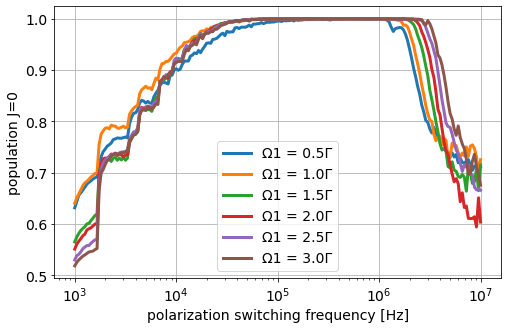

In [73]:
fig, ax = plt.subplots(figsize = (8,5))

for Ωi in Main.Ω1s:
    m = Ωi == result_freq_Ω1_scan[:,0].real
    f = result_freq_Ω1_scan[m][:,1].real
    p = result_freq_Ω1_scan[m][:,2:6].sum(axis = 1).real
    ax.plot(f, p, lw = 3, label = f"Ω1 = {Ωi/Γ:.1f}Γ")

ax.legend(fontsize = 14)
ax.set_xlabel('polarization switching frequency [Hz]')
ax.set_ylabel('population J=0')

ax.grid(True)
ax.set_xscale('log')

set_fontsize(ax, 14)

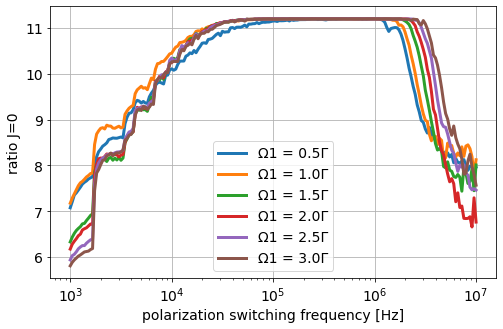

In [75]:
fig, ax = plt.subplots(figsize = (8,5))

for Ωi in Main.Ω1s:
    m = Ωi == result_freq_Ω1_scan[:,0].real
    f = result_freq_Ω1_scan[m][:,1].real
    r = result_freq_Ω1_scan[m][:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real
    ax.plot(f, r, lw = 3, label = f"Ω1 = {Ωi/Γ:.1f}Γ")

ax.legend(fontsize = 14)
ax.set_xlabel('polarization switching frequency [Hz]')
ax.set_ylabel('ratio J=0')

ax.grid(True)

ax.set_xscale('log')

set_fontsize(ax, 14)

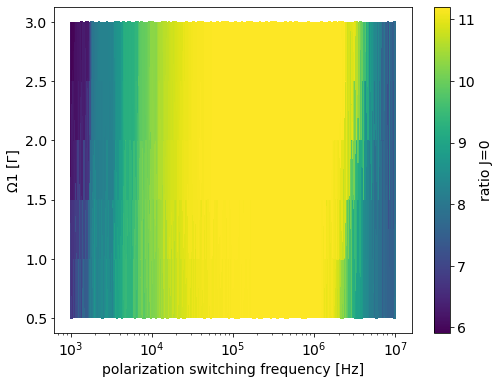

In [76]:
x = result_freq_Ω1_scan[:,1].real
y = result_freq_Ω1_scan[:,0].real/Γ
z = result_freq_Ω1_scan[:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real

fig, ax = plt.subplots(figsize = (8,6))
# cs = ax.tricontourf(x,y,z, levels = 15)
cs = ax.tripcolor(x,y,z)

ax.set_xscale('log')

ax.set_xlabel('polarization switching frequency [Hz]')
ax.set_ylabel('Ω1 [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ratio J=0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

### Disable laser polarization switching and scan detuning

In [77]:
Main.freqs = np.logspace(-3,1,101)*1e6
Main.Δs = np.arange(0,8,1)*Γ
params = np.zeros([len(Main.freqs)*len(Main.Δs), 2])
params[:,0] = np.repeat(Main.Δs, len(Main.freqs))
params[:,1] = np.tile(Main.freqs, len(Main.Δs))
Main.params = params

In [78]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617080212701e9, 1.617080212701e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000990) open, 0 bytes waiting), 0, 0, 0)>

In [79]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [81]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [82]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[Ω; 0; Ω1; params[i,2]; Ω2; params[i,2]; params[i,1]])
end
""")

<PyCall.jlwrap prob_func>

In [83]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [84]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

2382.1128031

In [85]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [86]:
result_freq_Δ_scan = np.empty([len(Main.params),67+2], dtype = 'complex')
result_freq_Δ_scan[:,:2] = Main.params.copy()
result_freq_Δ_scan[:,2:] = ens_u.copy()

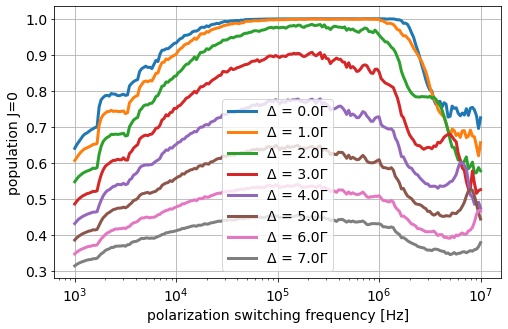

In [87]:
fig, ax = plt.subplots(figsize = (8,5))

for Δi in Main.Δs:
    m = Δi == result_freq_Δ_scan[:,0].real
    f = result_freq_Δ_scan[m][:,1].real
    p = result_freq_Δ_scan[m][:,2:6].sum(axis = 1).real
    ax.plot(f, p, lw = 3, label = f"Δ = {Δi/Γ:.1f}Γ")

ax.legend(fontsize = 14)
ax.set_xlabel('polarization switching frequency [Hz]')
ax.set_ylabel('population J=0')

ax.grid(True)
ax.set_xscale('log')

set_fontsize(ax, 14)

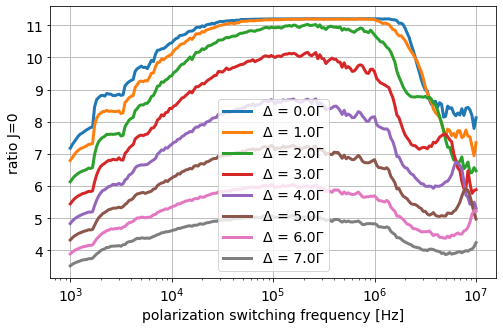

In [90]:
fig, ax = plt.subplots(figsize = (8,5))

for Δi in Main.Δs:
    m = Δi == result_freq_Δ_scan[:,0].real
    f = result_freq_Δ_scan[m][:,1].real
    r = result_freq_Δ_scan[m][:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real
    ax.plot(f, r, lw = 3, label = f"Δ = {Δi/Γ:.1f}Γ")

ax.legend(fontsize = 14)
ax.set_xlabel('polarization switching frequency [Hz]')
ax.set_ylabel('ratio J=0')

ax.grid(True)

ax.set_xscale('log')

set_fontsize(ax, 14)

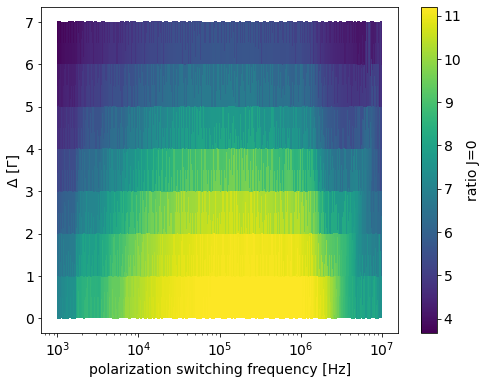

In [92]:
x = result_freq_Δ_scan[:,1].real
y = result_freq_Δ_scan[:,0].real/Γ
z = result_freq_Δ_scan[:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real

fig, ax = plt.subplots(figsize = (8,6))
# cs = ax.tricontourf(x,y,z, levels = 15)
cs = ax.tripcolor(x,y,z)

ax.set_xscale('log')

ax.set_xlabel('polarization switching frequency [Hz]')
ax.set_ylabel('Δ [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ratio J=0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)